In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pyspark
import os
import matplotlib.pyplot as plt
import numpy as np
import pymongo

print(pyspark.__version__)

3.5.6


In [5]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/usr/local/spark"
os.environ["PATH"] = f"{os.environ['SPARK_HOME']}/bin:{os.environ['JAVA_HOME']}/bin:" + os.environ["PATH"]

In [6]:

spark = SparkSession.builder \
    .appName("SparkAnalysis") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:10.3.0") \
    .getOrCreate()

df = (spark.read.option("sep", "\t")
               .option("header", "true")
               .csv("hdfs://localhost:54310/user/ubuntu/books_dataset_output/mapreduce_genres"))

df.show(10)

25/09/24 13:03:51 WARN Utils: Your hostname, dsbda-vm resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
25/09/24 13:03:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/usr/local/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-4706118b-9e4d-4976-9849-88f874d3e01f;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;10.3.0 in central
	found org.mongodb#mongodb-driver-sync;4.8.2 in central
	[4.8.2] org.mongodb#mongodb-driver-sync;[4.8.1,4.8.99)
	found org.mongodb#bson;4.8.2 in central
	found org.mongodb#mongodb-driver-core;4.8.2 in central
	found org.mongodb#bson-record-codec;4.8.2 in central
downloading https://repo1.maven.org/maven2/org/mongodb/spark/mongo-spark-connector_2.12/10.3.0/mongo-spark-connector_2.12-10.3.0.jar ...
	[SUCCESSFUL ] org.mongodb.spark#mongo-spark-connector_2.12;10.3.0!mongo-spark-connector_2.12.jar (193ms)
:: resolution report :: resolve 1878ms :: artifacts dl 203ms
	:: modules in use:
	org.mongodb#bson;4.8.2 from central in

+----------+---------+---------+-----+---------+---------+
|      word|pos_count|neg_count|total|pos_ratio|neg_ratio|
+----------+---------+---------+-----+---------+---------+
|   ability|      167|       18|  185|   0.9027|   0.0973|
|      able|      533|       47|  580|   0.9190|   0.0810|
|  abortion|       91|       18|  109|   0.8349|   0.1651|
|     above|      140|       30|  170|   0.8235|   0.1765|
|  absolute|       79|       17|   96|   0.8229|   0.1771|
|absolutely|      227|       41|  268|   0.8470|   0.1530|
|     abuse|       57|       19|   76|   0.7500|   0.2500|
|  academic|       51|       10|   61|   0.8361|   0.1639|
|    accept|       59|       17|   76|   0.7763|   0.2237|
|    access|       53|       16|   69|   0.7681|   0.2319|
+----------+---------+---------+-----+---------+---------+
only showing top 10 rows



Post-processing filter: remove most frequent words that are not polarized

In [7]:
df = (df
      .withColumn("pos_count", F.col("pos_count").cast("int"))
      .withColumn("neg_count", F.col("neg_count").cast("int"))
      .withColumn("pos_ratio", F.col("pos_ratio").cast("double"))
      .withColumn("neg_ratio", F.col("neg_ratio").cast("double"))
      .withColumn("total", F.col("total").cast("int"))
)

df_sorted = df.orderBy(F.col("total").desc())

# find the top_n most common words
top_n = 20
top_common = df_sorted.limit(top_n)

# filter: among the most common words, remove the ones that are not polarized
top_common_filtered = top_common.filter(
    (F.col("pos_ratio") < 0.9) & (F.col("neg_ratio") < 0.9)
)
words_to_remove = [row["word"] for row in top_common_filtered.select("word").collect()]
print("Removed words:", words_to_remove)

# create the new filtered df
df_filtered = df.filter(~F.col("word").isin(words_to_remove))

df_filtered.orderBy(F.col("total").desc()).show(20, truncate=False)

Removed words: ['book', 'read', 'quot', 'his', 'her', 'all', 'will', 'like', 'there', 'would', 'some', 'books', 'good', 'can', 'their', 'story', 'time', 'well', 'other']
+----------+---------+---------+-----+---------+---------+
|word      |pos_count|neg_count|total|pos_ratio|neg_ratio|
+----------+---------+---------+-----+---------+---------+
|great     |2804     |211      |3015 |0.93     |0.07     |
|life      |2446     |250      |2696 |0.9073   |0.0927   |
|many      |2248     |424      |2672 |0.8413   |0.1587   |
|reading   |2216     |379      |2595 |0.8539   |0.1461   |
|first     |2146     |421      |2567 |0.836    |0.164    |
|only      |2058     |508      |2566 |0.802    |0.198    |
|it's      |2045     |368      |2413 |0.8475   |0.1525   |
|get       |1879     |491      |2370 |0.7928   |0.2072   |
|much      |1784     |486      |2270 |0.7859   |0.2141   |
|even      |1762     |461      |2223 |0.7926   |0.2074   |
|people    |1796     |392      |2188 |0.8208   |0.1792   |
|rea

Post-processing filter: some words are case-specific. They appear few times, mostly in a single class (positive or negative) and are not informative. I removed them

In [8]:
# max frequency for positive and negative classes
max_pos = df_filtered.agg(F.max("pos_count")).collect()[0][0]
max_neg = df_filtered.agg(F.max("neg_count")).collect()[0][0]

min_freq_pos = int(max_pos * 0.1)
min_freq_neg = int(max_neg * 0.1)

# Remove words that appear mostly in a single class, and have a low absolute frequency
mask_remove = (
    ((F.col("pos_count") > F.col("neg_count")) & (F.col("neg_count") < 15) & (F.col("total") < min_freq_pos)) |
    ((F.col("neg_count") > F.col("pos_count")) & (F.col("pos_count") < 5) & (F.col("total") < min_freq_neg))
)

words_to_remove = df_filtered.filter(mask_remove).select("word").rdd.flatMap(lambda x: x).collect()
print("Removed words:", words_to_remove)

df_filtered2 = df_filtered.filter(~mask_remove)

Removed words: ['academic', 'accessible', 'accident', 'accounts', 'achieve', 'active', 'added', 'addition', 'address', 'adds', 'adults', 'advantage', 'adventure', 'adventures', 'afraid', 'african', 'ages', 'ahead', 'aid', 'alien', 'alike', 'alive', 'alliance', 'allows', 'alot', 'alten', 'alternative', 'amazed', "america's", 'amusing', 'amy', 'anatomy', 'anecdotes', 'anger', 'animal', 'answered', 'answers', 'anybody', 'anymore', 'anywhere', 'apparent', 'appreciate', 'appreciated', 'appropriate', 'area', 'areas', 'army', 'artist', 'artists', 'arts', 'artwork', 'ashley', 'aspect', 'aspects', 'assume', 'attacks', 'aubrey', 'auel', 'awesome', "baby's", 'balance', 'balanced', 'baseball', 'basics', 'battles', 'beach', 'bear', 'beat', 'beautifully', 'beauty', 'bedtime', 'beginner', 'beginners', 'beings', 'belief', 'benefit', 'besides', 'bipolar', 'birth', 'birthday', 'bizarre', 'blackjack', 'blood', 'blue', 'bodies', 'bond', 'bonfire', 'bookstore', 'born', 'bosch', 'bounty', 'box', 'boys', 'br

In [9]:
# Show the "most positive words"
top_pos = df_filtered2.orderBy(F.col("pos_ratio").desc()).limit(20)
top_pos.show()

+-----------+---------+---------+-----+---------+---------+
|       word|pos_count|neg_count|total|pos_ratio|neg_ratio|
+-----------+---------+---------+-----+---------+---------+
|  stephanie|      304|        9|  313|   0.9712|   0.0288|
|      thank|      274|       11|  285|   0.9614|   0.0386|
|   provides|      285|       13|  298|   0.9564|   0.0436|
|      heart|      428|       20|  448|   0.9554|   0.0446|
|  wonderful|      806|       38|  844|    0.955|    0.045|
|   favorite|      379|       18|  397|   0.9547|   0.0453|
|  excellent|      956|       47| 1003|   0.9531|   0.0469|
|     highly|      750|       38|  788|   0.9518|   0.0482|
|     helped|      268|       14|  282|   0.9504|   0.0496|
|  enjoyable|      266|       15|  281|   0.9466|   0.0534|
|       easy|      677|       39|  716|   0.9455|   0.0545|
|      humor|      310|       18|  328|   0.9451|   0.0549|
|fascinating|      343|       21|  364|   0.9423|   0.0577|
|        fun|      564|       36|  600| 

In [10]:
# Show the "most negative words"
top_neg = df_filtered2.orderBy(F.col("neg_ratio").desc()).limit(20)
top_neg.show()

+--------------+---------+---------+-----+---------+---------+
|          word|pos_count|neg_count|total|pos_ratio|neg_ratio|
+--------------+---------+---------+-----+---------+---------+
|        poorly|       19|       74|   93|   0.2043|   0.7957|
|         waste|       47|      163|  210|   0.2238|   0.7762|
|    ridiculous|       18|       59|   77|   0.2338|   0.7662|
| disappointing|       27|       83|  110|   0.2455|   0.7545|
|       shallow|       17|       35|   52|   0.3269|   0.6731|
|disappointment|       34|       68|  102|   0.3333|   0.6667|
|       kubrick|       21|       41|   62|   0.3387|   0.6613|
|         awful|       29|       56|   85|   0.3412|   0.6588|
|      annoying|       25|       46|   71|   0.3521|   0.6479|
|         glass|       41|       70|  111|   0.3694|   0.6306|
|        stupid|       36|       60|   96|    0.375|    0.625|
|        guilty|       35|       58|   93|   0.3763|   0.6237|
|        errors|       36|       58|   94|    0.383|   

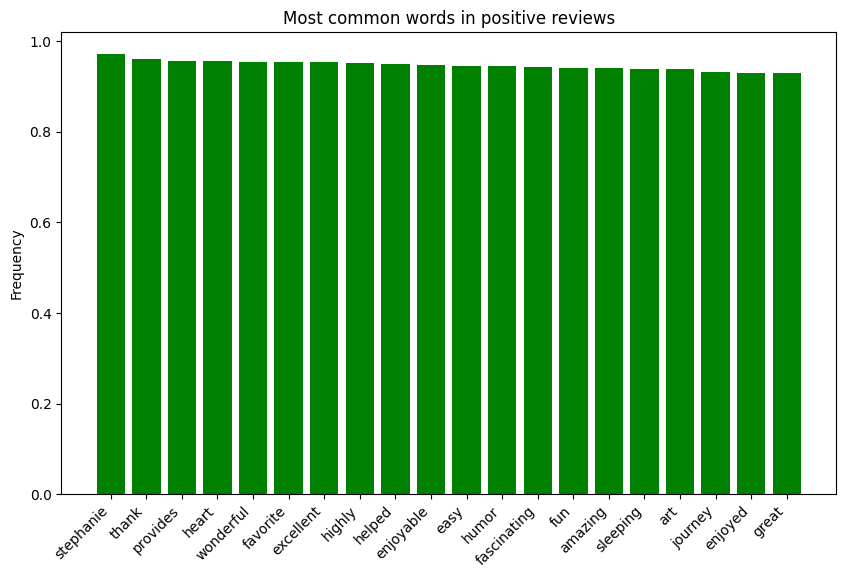

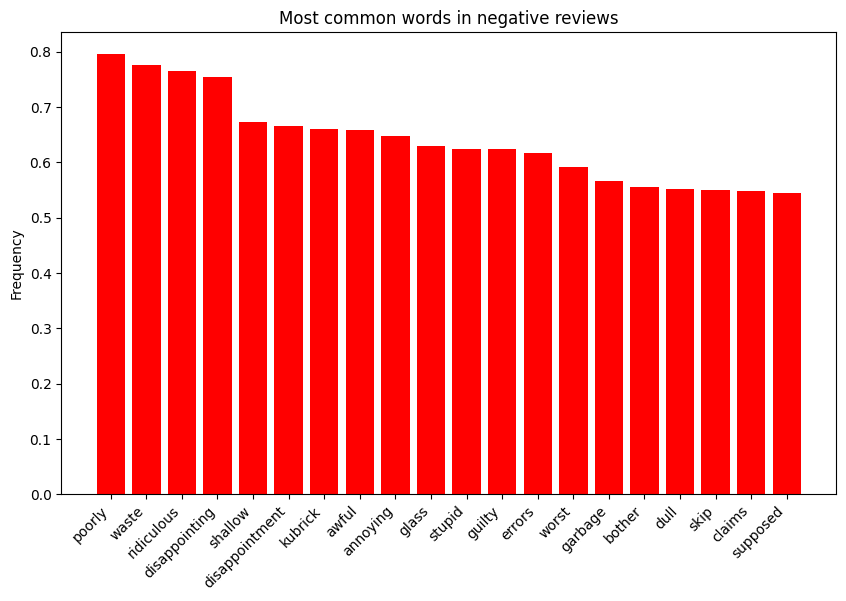

In [11]:
# plot "most positive words"
top_pos = df_filtered2.orderBy(F.col("pos_ratio").desc()).limit(20)
top_pos_pd = top_pos.toPandas()

plt.figure(figsize=(10,6))
plt.bar(top_pos_pd["word"], top_pos_pd["pos_ratio"], color="green")
plt.xticks(rotation=45, ha="right")
plt.title("Most common words in positive reviews")
plt.ylabel("Frequency")
plt.show()

# plot "most negative words"
top_neg = df_filtered2.orderBy(F.col("neg_ratio").desc()).limit(20)
top_neg_pd = top_neg.toPandas()

plt.figure(figsize=(10,6))
plt.bar(top_neg_pd["word"], top_neg_pd["neg_ratio"], color="red")
plt.xticks(rotation=45, ha="right")
plt.title("Most common words in negative reviews")
plt.ylabel("Frequency")
plt.show()


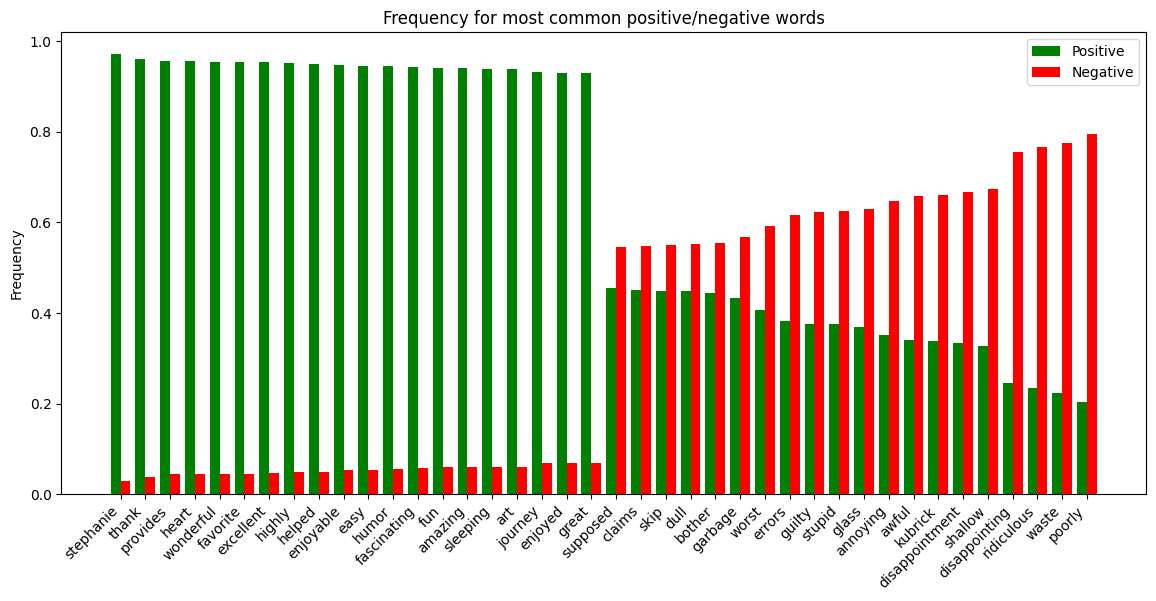

In [12]:
top_pos = df_filtered2.orderBy(F.col("pos_ratio").desc()).limit(20)
top_neg = df_filtered2.orderBy(F.col("neg_ratio").desc()).limit(20)

selected_words = list(set(top_pos.select("word").rdd.flatMap(lambda x: x).collect()) |
                      set(top_neg.select("word").rdd.flatMap(lambda x: x).collect()))

df_selected = df_filtered2.filter(F.col("word").isin(selected_words))

df_selected = df_selected.orderBy(F.col("pos_ratio").desc())

df_selected_pd = df_selected.toPandas()

x = np.arange(len(df_selected_pd))
width = 0.4

plt.figure(figsize=(14,6))
plt.bar(x - width/2, df_selected_pd["pos_ratio"], width, label="Positive", color="green")
plt.bar(x + width/2, df_selected_pd["neg_ratio"], width, label="Negative", color="red")

plt.xticks(x, df_selected_pd["word"], rotation=45, ha="right")
plt.title("Frequency for most common positive/negative words")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [13]:
# import final data to MongoDB

df_filtered2.write \
    .format("mongodb") \
    .mode("overwrite") \
    .option("spark.mongodb.write.uri", "mongodb://127.0.0.1:27017") \
    .option("database", "mydb") \
    .option("collection", "df_filtered2") \
    .save()

print("Saved to MongoDB in collection mydb.df_filtered2")

Saved to MongoDB in collection mydb.df_filtered2


In [15]:
# check if it works
df_mongo = spark.read \
    .format("mongodb") \
    .option("spark.mongodb.read.uri", "mongodb://127.0.0.1:27017") \
    .option("database", "mydb") \
    .option("collection", "df_filtered2") \
    .load()

df_mongo.show(10, truncate=False)

+------------------------+---------+---------+---------+---------+-----+----------+
|_id                     |neg_count|neg_ratio|pos_count|pos_ratio|total|word      |
+------------------------+---------+---------+---------+---------+-----+----------+
|68d3d0328b2d8c6ac97c2aac|18       |0.0973   |167      |0.9027   |185  |ability   |
|68d3d0328b2d8c6ac97c2aad|47       |0.081    |533      |0.919    |580  |able      |
|68d3d0328b2d8c6ac97c2aae|18       |0.1651   |91       |0.8349   |109  |abortion  |
|68d3d0328b2d8c6ac97c2aaf|30       |0.1765   |140      |0.8235   |170  |above     |
|68d3d0328b2d8c6ac97c2ab0|17       |0.1771   |79       |0.8229   |96   |absolute  |
|68d3d0328b2d8c6ac97c2ab1|41       |0.153    |227      |0.847    |268  |absolutely|
|68d3d0328b2d8c6ac97c2ab2|19       |0.25     |57       |0.75     |76   |abuse     |
|68d3d0328b2d8c6ac97c2ab3|17       |0.2237   |59       |0.7763   |76   |accept    |
|68d3d0328b2d8c6ac97c2ab4|16       |0.2319   |53       |0.7681   |69   |acce